## 載入所需套件

In [1]:
# 資料處理分析繪圖所需的套件
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns

# 機器學習所需的套件
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

# 深度學習所需的套件
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

## 從St. Louis FED 網站上下載所需的資料 https://fred.stlouisfed.org/

In [3]:
# Get the data by webscapping using pandas datareader
tsy_tickers = ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30',
               'TREAST', # -- U.S. Treasury securities held by the Federal Reserve ( Millions of Dollars )
               'FYGFDPUN', # -- Federal Debt Held by the Public ( Millions of Dollars )
               'FDHBFIN', # -- Federal Debt Held by Foreign and International Investors ( Billions of Dollars )
               'GFDEBTN', # -- Federal Debt: Total Public Debt ( Millions of Dollars )
               'BAA10Y', # -- Baa Corporate Bond Yield Relative to Yield on 10-Year
              ]
tsy_data = web.DataReader(tsy_tickers, 'fred').dropna(how='all').ffill()
tsy_data['FDHBFIN'] = tsy_data['FDHBFIN'] * 1000
tsy_data['GOV_PCT'] = tsy_data['TREAST'] / tsy_data['GFDEBTN']
tsy_data['HOM_PCT'] = tsy_data['FYGFDPUN'] / tsy_data['GFDEBTN']
tsy_data['FOR_PCT'] = tsy_data['FDHBFIN'] / tsy_data['GFDEBTN']

In [4]:
return_period = 5
#Y = tsy_data.loc[:, ['DGS1MO', 'DGS5', 'DGS30']].diff(return_period).shift(-return_period)
#return_period = 5
Y = tsy_data.loc[:, ['DGS1MO', 'DGS5', 'DGS30']].shift(-return_period)
Y.columns = [col+'_pred' for col in Y.columns]

#X = tsy_data.loc[:, ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30', 'GOV_PCT', 'HOM_PCT', 'FOR_PCT', 'BAA10Y']].diff(return_period)
X = tsy_data.loc[:, ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30', 'GOV_PCT', 'HOM_PCT', 'FOR_PCT', 'BAA10Y']]

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.columns]
X = dataset.loc[:, X.columns]

In [5]:
dataset.head()

,DGS1MO_pred,DGS5_pred,DGS30_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
DATE,,,,,,,,,,,,,,,
2017-04-01,0.77,1.92,3.00,0.74,0.76,1.03,1.27,1.93,2.22,2.40,3.02,0.124182,0.724173,0.310004,2.24
2017-04-07,0.76,1.79,2.92,0.77,0.82,1.08,1.29,1.92,2.20,2.38,3.00,0.124188,0.724173,0.310004,2.24
2017-04-17,0.74,1.81,2.93,0.76,0.83,1.04,1.21,1.79,2.07,2.26,2.92,0.124193,0.724173,0.310004,2.29
2017-04-24,0.67,1.84,3.00,0.74,0.81,1.03,1.25,1.81,2.09,2.28,2.93,0.124197,0.724173,0.310004,2.28
2017-05-01,0.73,1.91,3.02,0.67,0.83,1.09,1.28,1.84,2.13,2.33,3.00,0.124202,0.724173,0.310004,2.29


In [6]:
dataset.tail()

,DGS1MO_pred,DGS5_pred,DGS30_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
DATE,,,,,,,,,,,,,,,
2022-01-21,0.04,1.61,2.07,0.05,0.17,0.58,1.01,1.54,1.70,1.75,2.07,0.192231,0.782259,0.261314,1.84
2022-01-28,0.05,1.78,2.23,0.04,0.19,0.75,1.15,1.61,1.74,1.78,2.07,0.193003,0.782259,0.261314,1.91
2022-02-04,0.03,1.84,2.24,0.05,0.23,0.89,1.31,1.78,1.90,1.93,2.23,0.193405,0.782259,0.261314,1.92
2022-02-11,0.03,1.82,2.24,0.03,0.36,1.07,1.50,1.84,1.92,1.92,2.24,0.193531,0.782259,0.261314,2.00
2022-02-18,0.06,1.71,2.17,0.03,0.35,1.03,1.47,1.82,1.90,1.92,2.24,0.193760,0.782259,0.261314,2.13


In [7]:
dataset.shape

(248, 15)

In [8]:
pd.set_option('precision', 3)
dataset.describe()

,DGS1MO_pred,DGS5_pred,DGS30_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
count,248.000,248.000,248.000,248.000,248.000,248.000,248.000,248.000,248.000,248.000,248.000,248.000,248.000,248.000,248.000
mean,1.035,1.590,2.402,1.037,1.088,1.217,1.313,1.591,1.778,1.921,2.406,0.133,0.752,0.284,2.168
std,0.900,0.862,0.606,0.898,0.911,0.954,0.946,0.862,0.804,0.754,0.607,0.034,0.024,0.020,0.400
min,0.000,0.220,1.180,0.000,0.000,0.040,0.110,0.220,0.400,0.560,1.180,0.091,0.723,0.250,1.590
25%,0.077,0.808,1.938,0.080,0.098,0.140,0.210,0.808,1.170,1.407,1.938,0.103,0.732,0.264,1.910
50%,1.000,1.695,2.345,1.000,1.070,1.265,1.410,1.695,1.830,1.910,2.350,0.120,0.741,0.294,2.110
75%,1.857,2.333,2.960,1.857,1.942,2.080,2.235,2.333,2.433,2.540,2.960,0.166,0.781,0.301,2.262
max,2.510,3.090,3.430,2.510,2.490,2.740,2.980,3.090,3.170,3.240,3.430,0.194,0.785,0.311,4.130


## 對資料進行繪圖比較

<AxesSubplot:xlabel='DATE'>

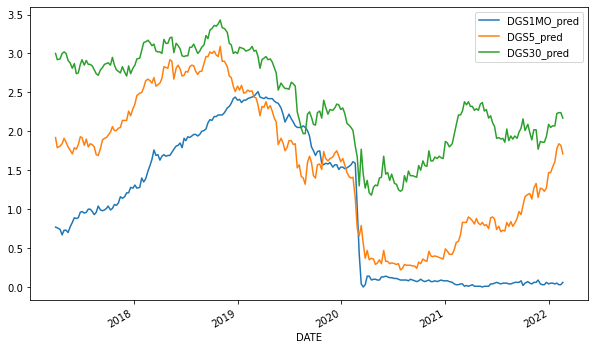

In [9]:
Y.plot(figsize=(10,6))

## 繪製直方圖

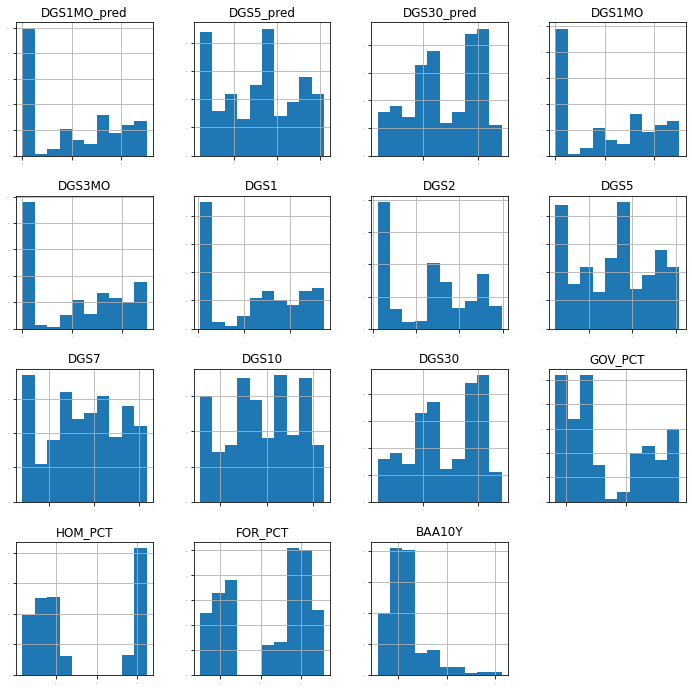

In [10]:
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

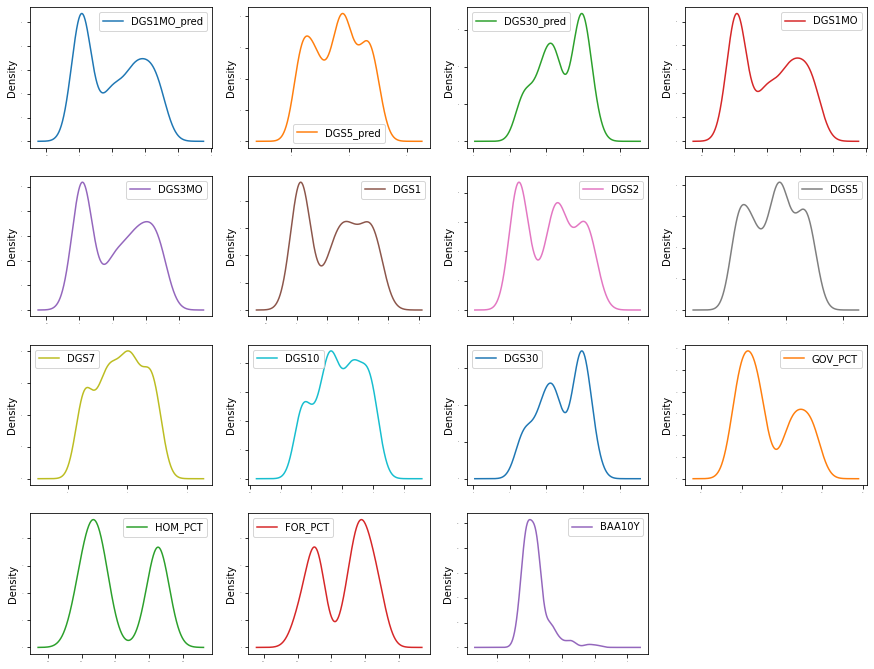

In [11]:
# density
dataset.plot(kind='density', subplots=True, layout=(5,4), sharex=False, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

## 繪製箱型圖

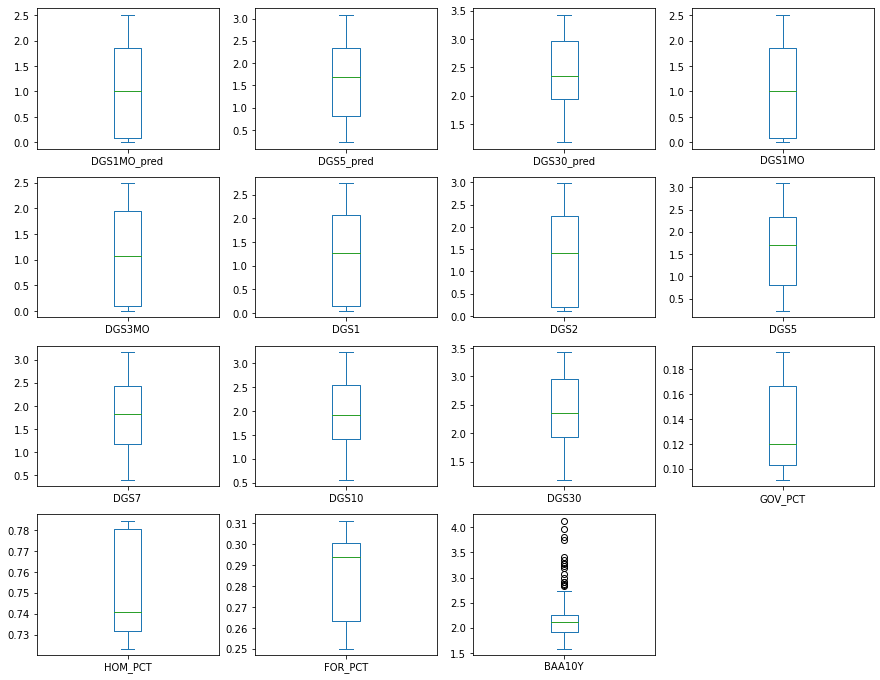

In [12]:
dataset.plot(kind='box', subplots=True, layout=(5,4), sharex=False, sharey=False, figsize=(15,15))
pyplot.show()

## 繪製債券之間的相關係數圖表

<AxesSubplot:title={'center':'Correlation Matrix'}>

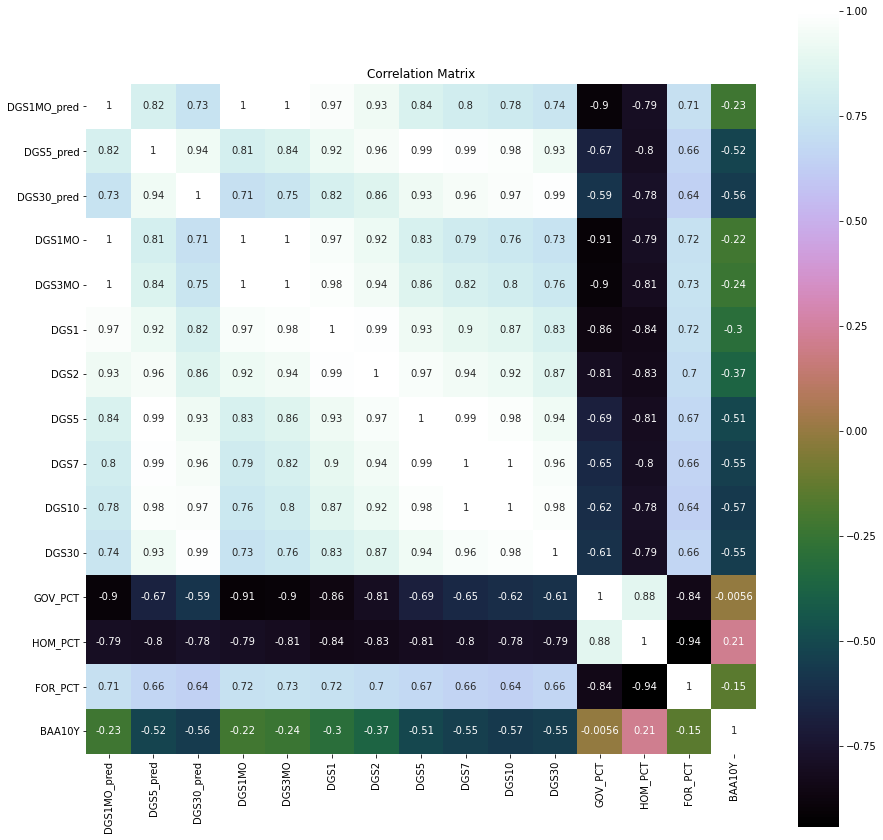

In [13]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

In [14]:
# Scatterplot Matrix
#pyplot.figure(figsize=(15,15))
#scatter_matrix(dataset,figsize=(15,16))
#pyplot.show()

## 運用時間序列去對債券資料拆解查看是否有趨勢存在

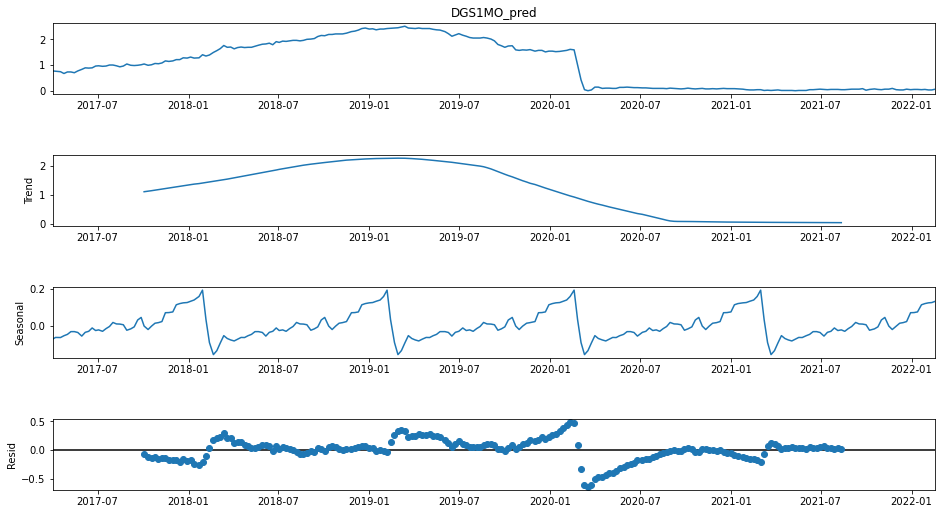

In [15]:
temp_Y = dataset['DGS1MO_pred']
res = sm.tsa.seasonal_decompose(temp_Y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

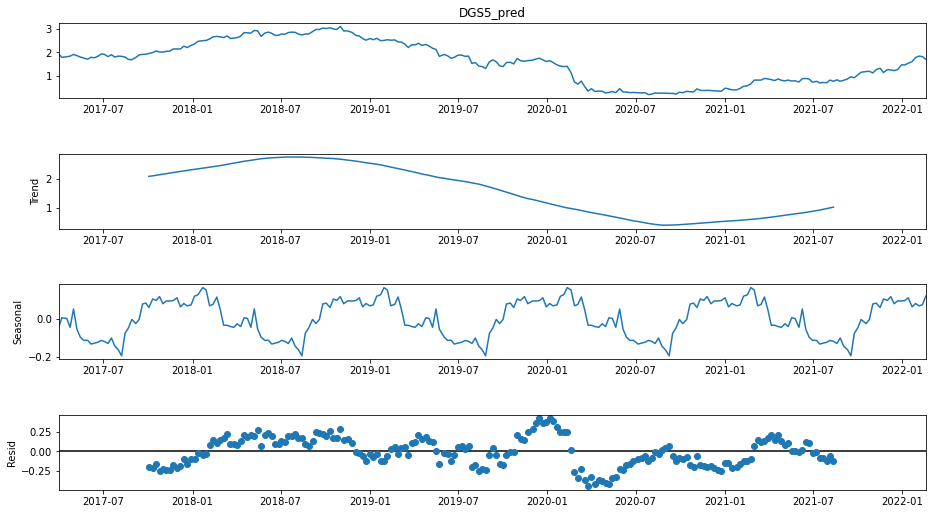

In [16]:
temp_Y = dataset['DGS5_pred']
res = sm.tsa.seasonal_decompose(temp_Y, period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

In [17]:
#https://ithelp.ithome.com.tw/articles/10205535

In [18]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
for col in Y.columns:
    temp_Y = dataset[col]
    temp_X = dataset.loc[:, X.columns]
    fit = bestfeatures.fit(temp_X,temp_Y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    print(col)
    print(featureScores.nlargest(10,'Score'))  #print 10 best features
    print('--------------')

DGS1MO_pred
     Specs      Score
0   DGS1MO  41564.608
1   DGS3MO  35087.382
2     DGS1   3967.065
3     DGS2   1551.692
8  GOV_PCT   1053.532
4     DGS5    578.817
5     DGS7    436.995
9  HOM_PCT    416.024
6    DGS10    376.187
7    DGS30    303.424
--------------
DGS5_pred
     Specs      Score
4     DGS5  23692.394
5     DGS7  12399.531
6    DGS10   5409.738
3     DGS2   2933.201
7    DGS30   1706.623
2     DGS1   1351.145
1   DGS3MO    612.309
0   DGS1MO    476.260
9  HOM_PCT    447.957
8  GOV_PCT    202.045
--------------
DGS30_pred
      Specs     Score
7     DGS30  9497.384
6     DGS10  4414.173
5      DGS7  2588.385
4      DGS5  1591.463
3      DGS2   685.153
2      DGS1   509.356
9   HOM_PCT   388.376
1    DGS3MO   314.538
0    DGS1MO   257.218
10  FOR_PCT   170.473
--------------


In [19]:
# split out validation dataset for the end

validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [20]:
#https://zhuanlan.zhihu.com/p/250253050

In [21]:
# test options for regression
num_folds = 10
scoring = 'neg_mean_squared_error'

In [22]:
#spot check the algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
#Neural Network
models.append(('MLP', MLPRegressor()))

In [23]:
kfold_results = []
names = []
validation_results = []
train_results = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    names.append(name)

    # Finally we Train on the full period and test against validation
    res = model.fit(X_train, Y_train)
    validation_result = np.mean(np.square(res.predict(X_validation) - Y_validation))
    validation_results.append(validation_result)
    train_result = np.mean(np.square(res.predict(X_train) - Y_train))
    train_results.append(train_result)
    
    msg = "%s: \nAverage CV error: %s \nStd CV Error: (%s) \nTraining Error:\n%s \nTest Error:\n%s" % \
    (name, str(cv_results.mean()), str(cv_results.std()), str(train_result), str(validation_result))
    print(msg)
    print('----------')

LR: 
Average CV error: 0.007412373663433475 
Std CV Error: (0.0023103599228992827) 
Training Error:
DGS1MO_pred    0.003
DGS5_pred      0.007
DGS30_pred     0.008
dtype: float64 
Test Error:
DGS1MO_pred    0.006
DGS5_pred      0.006
DGS30_pred     0.009
dtype: float64
----------
LASSO: 
Average CV error: 0.6281262312460566 
Std CV Error: (0.07778860185297984) 
Training Error:
DGS1MO_pred    0.796
DGS5_pred      0.723
DGS30_pred     0.349
dtype: float64 
Test Error:
DGS1MO_pred    0.856
DGS5_pred      0.813
DGS30_pred     0.436
dtype: float64
----------
EN: 
Average CV error: 0.38234842750574394 
Std CV Error: (0.05226861970743816) 
Training Error:
DGS1MO_pred    0.375
DGS5_pred      0.410
DGS30_pred     0.349
dtype: float64 
Test Error:
DGS1MO_pred    0.401
DGS5_pred      0.455
DGS30_pred     0.436
dtype: float64
----------
KNN: 
Average CV error: 0.008550772982456142 
Std CV Error: (0.00488206804081926) 
Training Error:
DGS1MO_pred    0.003
DGS5_pred      0.007
DGS30_pred     0.006
dt

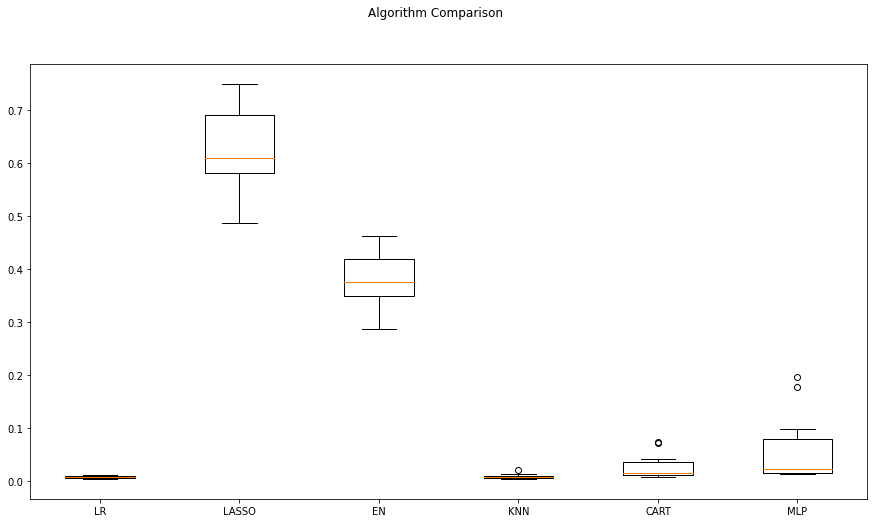

In [24]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

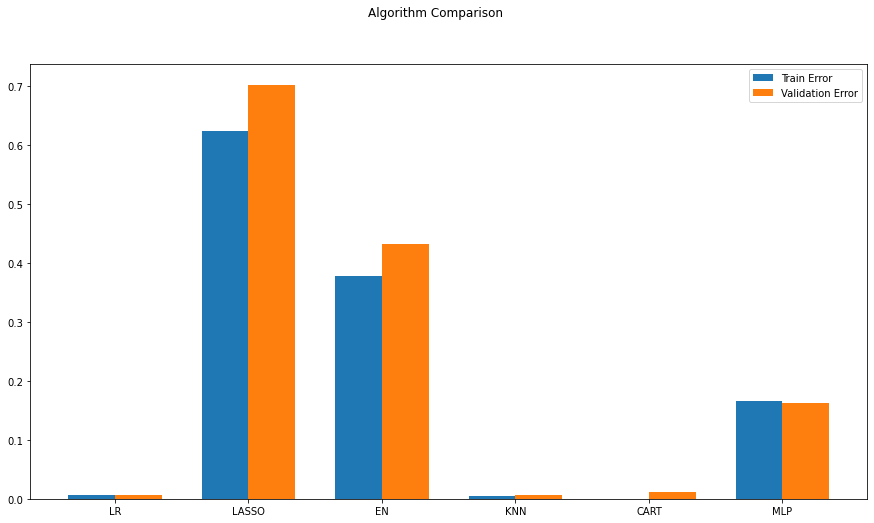

In [25]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, [x.mean() for x in train_results],  width=width, label='Train Error')
pyplot.bar(ind + width/2, [x.mean() for x in validation_results], width=width, label='Validation Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

In [26]:
# 7. Grid search : MLPRegressor 
'''
hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
    The ith element represents the number of neurons in the ith
    hidden layer.
'''
param_grid={'hidden_layer_sizes': [(20,), (50,), (20,20), (20, 30, 20)]}
model = MLPRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.028033 using {'hidden_layer_sizes': (20, 30, 20)}
-0.059067 (0.029750) with: {'hidden_layer_sizes': (20,)}
-0.035251 (0.030161) with: {'hidden_layer_sizes': (50,)}
-0.047315 (0.026999) with: {'hidden_layer_sizes': (20, 20)}
-0.028033 (0.024969) with: {'hidden_layer_sizes': (20, 30, 20)}


In [27]:
# prepare model
model = MLPRegressor(hidden_layer_sizes= (20, 30, 20))
model.fit(X_train, Y_train)

MLPRegressor(hidden_layer_sizes=(20, 30, 20))

In [28]:
# estimate accuracy on validation set
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
predictions = model.predict(X_validation)
mse_MLP = mean_squared_error(Y_validation, predictions)
r2_MLP = r2_score(Y_validation, predictions)

# prepare model
model_2 = LinearRegression()
model_2.fit(X_train, Y_train)
predictions_2 = model_2.predict(X_validation)

mse_OLS = mean_squared_error(Y_validation, predictions_2)
r2_OLS = r2_score(Y_validation, predictions_2)
print("MSE Regression = %f, MSE MLP = %f" % (mse_OLS, mse_MLP ))
print("R2 Regression = %f, R2 MLP = %f" % (r2_OLS, r2_MLP ))

MSE Regression = 0.006679, MSE MLP = 0.032247
R2 Regression = 0.988404, R2 MLP = 0.940504


In [29]:
train_size = int(len(X) * (1-validation_size))
X_train, X_validation = X[0:train_size], X[train_size:len(X)]
Y_train, Y_validation = Y[0:train_size], Y[train_size:len(X)]

modelMLP = MLPRegressor(hidden_layer_sizes= (50,))
modelOLS = LinearRegression()
model_MLP = modelMLP.fit(X_train, Y_train)
model_OLS = modelOLS.fit(X_train, Y_train)

Y_predMLP = pd.DataFrame(model_MLP.predict(X_validation), index=Y_validation.index,
                      columns=Y_validation.columns)

Y_predOLS = pd.DataFrame(model_OLS.predict(X_validation), index=Y_validation.index,
                      columns=Y_validation.columns)

<AxesSubplot:xlabel='DATE'>

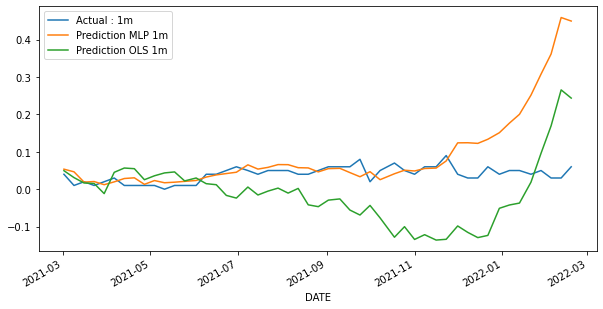

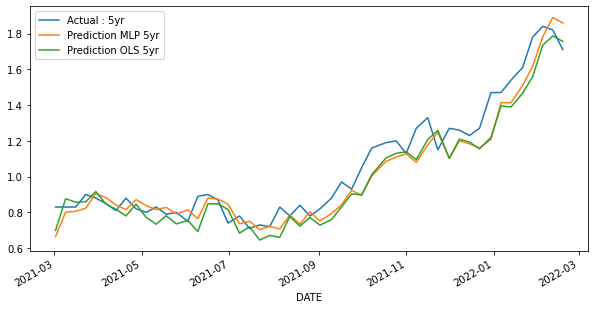

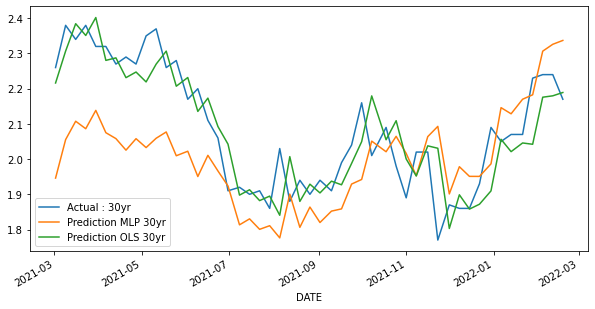

In [30]:
pd.DataFrame({'Actual : 1m': Y_validation.loc[:, 'DGS1MO_pred'],
              'Prediction MLP 1m': Y_predMLP.loc[:, 'DGS1MO_pred'],
              'Prediction OLS 1m': Y_predOLS.loc[:, 'DGS1MO_pred']}).plot(figsize=(10,5))

pd.DataFrame({'Actual : 5yr': Y_validation.loc[:, 'DGS5_pred'],
              'Prediction MLP 5yr': Y_predMLP.loc[:, 'DGS5_pred'],
              'Prediction OLS 5yr': Y_predOLS.loc[:, 'DGS5_pred']}).plot(figsize=(10,5))

pd.DataFrame({'Actual : 30yr': Y_validation.loc[:, 'DGS30_pred'],
              'Prediction MLP 30yr': Y_predMLP.loc[:, 'DGS30_pred'],
              'Prediction OLS 30yr': Y_predOLS.loc[:, 'DGS30_pred']}).plot(figsize=(10,5))